In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

import lightgbm as lgb


sys.path.append('../')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)


from config.paths import PROCESSED_DATA_PATH, CONFIG_PATH
from utils.file_management import read_yaml

In [2]:
seed = 42

In [3]:
df = pd.read_parquet(f'{PROCESSED_DATA_PATH}/preprocessed_dataset.parquet')
features = read_yaml(f'{CONFIG_PATH}/features.yaml')
target = 'price' #features['target']

# Train test split

In [4]:
pctg_train = 0.8
n_train = int(len(df) * pctg_train)
train_idx = df.sample(n=n_train, random_state=42).index
train = df.loc[train_idx]
test = df.loc[~df.index.isin(train_idx)]

In [5]:
def drop_features(df_):
    cols_to_use = [target, 'id', 'city', 'county', 'lotAreaUnits', 'parking', 'garageSpaces', 'hasGarage', 'pool',
                   'spa', 'homeType', 'livingAreaMts_log', 'yearBuilt', 'mapped_bathrooms', 'city_median_price',
                   'city_mean_price', 'county_median_price', 'county_mean_price', 'bedrooms', 'levels',
                   '5_knn_mean_price', '5_knn_median_price', '25_knn_mean_price', '25_knn_median_price']

    # Filtrar las columnas que existen en el DataFrame
    cols_to_use = [col for col in cols_to_use if col in df_.columns]

    df_ = df_[cols_to_use]

    return df_

In [6]:
def calculate_statistic(df, feature, statistic):
    df[f'{feature}_{statistic}_price'] = df.groupby(feature)['price'].transform(statistic)
    return df

In [7]:
import pandas as pd
from sklearn.neighbors import BallTree

def knn_property_price(df_, n_neighbors=3, statistic='mean'):

    df_['latitude'] = df_['latitude'].astype(float)
    df_['longitude'] = df_['longitude'].astype(float)

    # Combina las coordenadas en una matriz
    coords = df_[['latitude', 'longitude']].values

    # Construye un árbol de bolas para buscar vecinos cercanos eficientemente
    tree = BallTree(coords, leaf_size=15, metric='haversine')

    # Para cada propiedad, encuentra los índices de las N propiedades más cercanas
    _, indices = tree.query(coords, k=n_neighbors + 1)

    # Calcula la estadística especificada de las propiedades cercanas para cada fila
    if statistic == 'mean':
        df_[f'{n_neighbors}_knn_{statistic}_price'] = [df_.iloc[idx]['price'][1:].astype(float).mean() for idx in indices]
    elif statistic == 'median':
        df_[f'{n_neighbors}_knn_{statistic}_price'] = [df_.iloc[idx]['price'][1:].astype(float).median() for idx in indices]
    elif statistic == 'std':
        df_[f'{n_neighbors}_knn_{statistic}_price'] = [df_.iloc[idx]['price'][1:].astype(float).std() for idx in indices]
    # Puedes agregar más opciones según tus necesidades

    return df_

In [8]:
def encode_categorical_variables(df):
  """
  Encodes categorical variables in a dataset.

  Args:
    df: The dataset.

  Returns:
    The encoded dataset.
  """

  # Get the categorical variables.
  categorical_variables = [
      var for var in df.columns if df[var].dtype.name == "object"
  ]

  # Encode the categorical variables.
  for var in categorical_variables:
    df[var] = df[var].astype("category")
    df[var] = df[var].cat.codes

  return df


In [9]:
# Crear la transformación con FunctionTransformer
city_median_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'city', 'statistic': 'median'})
city_mean_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'city', 'statistic': 'mean'})
county_median_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'county', 'statistic': 'median'})
county_mean_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'county', 'statistic': 'mean'})
_5_knn_median_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':5, 'statistic':'median'})
_5_knn_mean_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':5, 'statistic':'mean'})
_25_knn_median_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':25, 'statistic':'median'})
_25_knn_mean_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':25, 'statistic':'mean'})
encoding = FunctionTransformer(encode_categorical_variables, validate=False)
drop_features = FunctionTransformer(drop_features, validate=False)


# Definir la pipeline
pipeline = Pipeline([
    ('city_median_price', city_median_price),
    ('city_mean_price', city_mean_price),
    ('county_median_price', county_median_price),
    ('county_mean_price', county_mean_price),
    ('5_knn_median_price', _5_knn_median_price),
    ('5_knn_mean_price', _5_knn_mean_price),
    ('25_knn_median_price', _25_knn_median_price),
    ('25_knn_mean_price', _25_knn_mean_price),
    ('encoding', encoding),
    ('drop_features', drop_features)

])

# Aplicar la pipeline a tus datos
train_transformed = pipeline.transform(train.copy())

# Model

In [10]:
train_transformed

,price,id,city,county,lotAreaUnits,parking,garageSpaces,hasGarage,pool,spa,homeType,livingAreaMts_log,yearBuilt,mapped_bathrooms,city_median_price,city_mean_price,county_median_price,county_mean_price,bedrooms,levels,5_knn_mean_price,5_knn_median_price,25_knn_mean_price,25_knn_median_price
10930,1599000.000,1039,584,18,1,0,0.000,0.000,0,0,3,7.168,1952,NaN,1095000.000,1366969.022,880000.000,1188661.924,2.000,38,1361400.000,1299000.000,1531823.880,1300000.000
18956,509900.000,22595,849,44,0,1,0.000,0.000,1,0,3,7.705,1992,NaN,399900.000,445032.086,304500.000,394419.048,4.000,0,380980.000,385000.000,404480.000,379000.000
29384,324000.000,23339,964,45,0,0,0.000,0.000,0,0,3,7.667,1978,NaN,324000.000,441142.857,269500.000,413849.778,4.000,0,358800.000,350000.000,979512.000,449000.000
24846,2989000.000,6243,977,36,1,1,2.000,2.000,0,1,3,7.720,1981,NaN,2697000.000,2523612.500,799000.000,1038779.224,3.000,38,3313400.000,3500000.000,1673488.000,1250000.000
13599,575000.000,18493,223,54,0,0,0.000,0.000,0,0,3,8.021,1986,NaN,319000.000,370428.571,397000.000,480087.047,3.000,1,129800.000,129000.000,360720.000,298000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24463,1195000.000,1347,382,18,1,0,0.000,0.000,0,0,2,8.185,1961,NaN,780000.000,949084.818,880000.000,1188661.924,0.000,38,860780.000,859000.000,969948.000,850000.000
16526,362000.000,9731,455,29,1,0,0.000,0.000,0,1,0,6.213,1983,NaN,1149000.000,1289252.921,925000.000,1225710.750,1.000,12,1120300.000,1150000.000,1474235.960,1150000.000
6771,1248000.000,17844,906,42,1,1,0.000,0.000,0,0,3,7.217,1964,NaN,1175000.000,1240153.456,1299000.000,1562348.983,4.000,0,1450360.200,1325000.000,1152007.480,1228000.000
25628,899000.000,281,584,18,1,0,0.000,0.000,0,0,3,7.022,1906,NaN,1095000.000,1366969.022,880000.000,1188661.924,3.000,12,1221199.000,1180000.000,1189991.760,1139000.000


In [11]:
train_transformed[(train_transformed['county']==38) & (train_transformed['price']==499888.000)]

,price,id,city,county,lotAreaUnits,parking,garageSpaces,hasGarage,pool,spa,homeType,livingAreaMts_log,yearBuilt,mapped_bathrooms,city_median_price,city_mean_price,county_median_price,county_mean_price,bedrooms,levels,5_knn_mean_price,5_knn_median_price,25_knn_mean_price,25_knn_median_price
13499,499888.000,19065,1050,38,1,1,0.000,0.000,0,0,3,7.155,1956,NaN,788944.000,1014142.661,499000.000,647040.016,4.000,0,588367.600,399950.000,844015.520,599000.000


In [12]:
X = train_transformed.drop(columns='price')
y = train_transformed['price']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
model = lgb.LGBMRegressor(random_state=seed, n_estimators=1000)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 18844, number of used features: 22
[LightGBM] [Info] Start training from score 952161.323870


LGBMRegressor(n_estimators=1000, random_state=42)

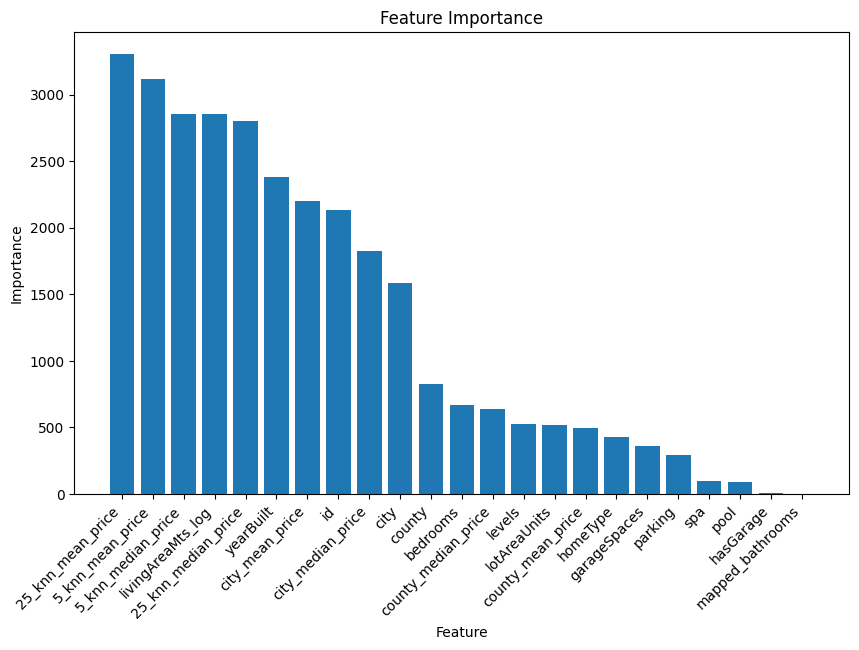

In [15]:
feature_importance = model.feature_importances_

# Crea un DataFrame con la importancia de las características
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
})

# Ordena el DataFrame por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Visualiza la importancia de las características en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

# Model evaluation

In [15]:
y_pred = model.predict(X_test)

In [16]:
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
mse = np.mean((y_test - y_pred)**2)
mae = np.mean(np.abs(y_test - y_pred))
median_absolute_error = np.median(np.abs(y_test - y_pred))
r2 = np.corrcoef(y_test, y_pred)[0, 1]**2

print(f'RMSE: {int(rmse)}')
print(f'MSE : {int(mse)}')
print(f'MAE : {int(mae)}')
print(f'MeAE: {int(median_absolute_error)}')
print(f'R2  : {round(r2, 3)}')

RMSE: 500177
MSE : 250177996366
MAE : 260957
MeAE: 119248
R2  : 0.666


In [17]:
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
mse = np.mean((y_test - y_pred)**2)
mae = np.mean(np.abs(y_test - y_pred))
median_absolute_error = np.median(np.abs(y_test - y_pred))
r2 = np.corrcoef(y_test, y_pred)[0, 1]**2

print(f'RMSE: {int(rmse)}')
print(f'MSE : {int(mse)}')
print(f'MAE : {int(mae)}')
print(f'MeAE: {int(median_absolute_error)}')
print(f'R2  : {round(r2, 3)}')

RMSE: 500177
MSE : 250177996366
MAE : 260957
MeAE: 119248
R2  : 0.666


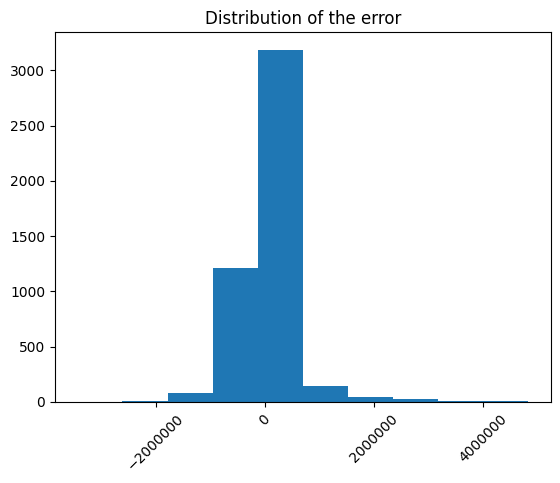

In [18]:
errors = y_test - y_pred
plt.hist(errors)
plt.title("Distribution of the error")

# Desactivar la notación científica en ambos ejes
plt.ticklabel_format(style='plain', axis='both')
plt.xticks(rotation=45)
plt.show()

# Apply pipeine to test

In [19]:
test_transformed = pipeline.transform(test.copy())

In [20]:
test_preds = model.predict(test_transformed.drop(columns='price'))
test_actual = test_transformed['price']

In [21]:
test_rmse = np.sqrt(np.mean((test_actual - test_preds)**2))
test_mse = np.mean((test_actual - test_preds)**2)
test_mae = np.mean(np.abs(test_actual - test_preds))
test_median_absolute_error = np.median(np.abs(test_actual - test_preds))
test_r2 = np.corrcoef(test_actual, test_preds)[0, 1]**2

print(f'RMSE: {int(test_rmse)}')
print(f'MSE : {int(test_mse)}')
print(f'MAE : {int(test_mae)}')
print(f'MeAE: {int(test_median_absolute_error)}')
print(f'R2  : {round(test_r2, 3)}')

RMSE: 514784
MSE : 265003058492
MAE : 322990
MeAE: 177640
R2  : 0.671


# Optuna

In [22]:
from utils.optimizer import optimize_lightgbm_params
from utils.train import train_lightgbm_model

In [23]:
# Uso de la función
# Supongamos que tienes un DataFrame df y el objetivo es predecir la columna 'target'
best_params = optimize_lightgbm_params(train_transformed.drop(target, axis=1), df[target], n_trials=25)
print(best_params)

[I 2024-01-03 16:11:56,564] A new study created in memory with name: no-name-2bb233d9-12c8-4beb-96e6-c255b4e7da68
/Users/robertogarces/data-science/projects/real-state/notebooks/../utils/optimizer.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
/Users/robertogarces/data-science/projects/real-state/notebooks/../utils/optimizer.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/robertogarces/data-science/projects/real-state/notebooks/../utils/optimizer.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature 

{'num_leaves': 2, 'learning_rate': 0.014933097513777627, 'feature_fraction': 0.403266412278718, 'bagging_fraction': 0.6259637804054402, 'bagging_freq': 9, 'reg_alpha': 8.891931410159718e-06, 'reg_lambda': 9.586455707217327e-06}


In [24]:
model = train_lightgbm_model(train_transformed, target, best_params)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 18844, number of used features: 22
[LightGBM] [Info] Start training from score 947213.509340
RMSE: 555169
MSE : 308213101263
MAE : 325168
MeAE: 184171
MAPE: 0
R2  : 0.6


In [25]:
train_transformed

,price,id,city,county,lotAreaUnits,parking,garageSpaces,hasGarage,pool,spa,homeType,livingAreaMts_log,yearBuilt,mapped_bathrooms,city_median_price,city_mean_price,county_median_price,county_mean_price,bedrooms,levels,5_knn_mean_price,5_knn_median_price,25_knn_mean_price,25_knn_median_price
10930,1599000.000,1039,584,18,1,0,0.000,0.000,0,0,3,7.168,1952,NaN,1095000.000,1366969.022,880000.000,1188661.924,2.000,38,1361400.000,1299000.000,1531823.880,1300000.000
18956,509900.000,22595,849,44,0,1,0.000,0.000,1,0,3,7.705,1992,NaN,399900.000,445032.086,304500.000,394419.048,4.000,0,380980.000,385000.000,404480.000,379000.000
29384,324000.000,23339,964,45,0,0,0.000,0.000,0,0,3,7.667,1978,NaN,324000.000,441142.857,269500.000,413849.778,4.000,0,358800.000,350000.000,979512.000,449000.000
24846,2989000.000,6243,977,36,1,1,2.000,2.000,0,1,3,7.720,1981,NaN,2697000.000,2523612.500,799000.000,1038779.224,3.000,38,3313400.000,3500000.000,1673488.000,1250000.000
13599,575000.000,18493,223,54,0,0,0.000,0.000,0,0,3,8.021,1986,NaN,319000.000,370428.571,397000.000,480087.047,3.000,1,129800.000,129000.000,360720.000,298000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24463,1195000.000,1347,382,18,1,0,0.000,0.000,0,0,2,8.185,1961,NaN,780000.000,949084.818,880000.000,1188661.924,0.000,38,860780.000,859000.000,969948.000,850000.000
16526,362000.000,9731,455,29,1,0,0.000,0.000,0,1,0,6.213,1983,NaN,1149000.000,1289252.921,925000.000,1225710.750,1.000,12,1120300.000,1150000.000,1474235.960,1150000.000
6771,1248000.000,17844,906,42,1,1,0.000,0.000,0,0,3,7.217,1964,NaN,1175000.000,1240153.456,1299000.000,1562348.983,4.000,0,1450360.200,1325000.000,1152007.480,1228000.000
25628,899000.000,281,584,18,1,0,0.000,0.000,0,0,3,7.022,1906,NaN,1095000.000,1366969.022,880000.000,1188661.924,3.000,12,1221199.000,1180000.000,1189991.760,1139000.000


In [26]:
test_rmse = np.sqrt(np.mean((test_actual - test_preds)**2))
test_mse = np.mean((test_actual - test_preds)**2)
test_mae = np.mean(np.abs(test_actual - test_preds))
test_median_absolute_error = np.median(np.abs(test_actual - test_preds))
test_r2 = np.corrcoef(test_actual, test_preds)[0, 1]**2

print(f'RMSE: {int(test_rmse)}')
print(f'MSE : {int(test_mse)}')
print(f'MAE : {int(test_mae)}')
print(f'MeAE: {int(test_median_absolute_error)}')
print(f'R2  : {round(test_r2, 3)}')

RMSE: 514784
MSE : 265003058492
MAE : 322990
MeAE: 177640
R2  : 0.671
